In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_addons as tfa

from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model



C:\Users\chimi\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\chimi\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\chimi\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
C:\Users\chimi\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV

# Project Title: Alzheimer's Disease Stages Classification from MRI Images

# Project Description:
- This goal of this project is to create a deep learning machine model using CNN that can correctly categorize Alzheimer's disease stages. Alzheimer's disease is a type of brain disorder that can gradually impair thinking and memory abilities as well as capacity to even perform basic task. The symptoms appear late-onset appear typically in patients in their mid-60s.It's considered rare to strike between the ages of 30 and 60. For older folks, Alzheimer disease can also cause dementia.Following are the stages of the disease: Preclinical stage, mild, moderate, and severe late stage. 

Citation: https://www.nia.nih.gov/health/what-alzheimers-disease
 https://www.hopkinsmedicine.org/health/conditions-and-diseases/alzheimers-disease/stages-of-alzheimer-disease
https://medium.com/geekculture/eda-for-image-classification-dcada9f2567a
https://www.kaggle.com/code/vishakansubramanian/alzheimer-s-disease-classification-notebook/notebook


# Data Loading

In [3]:
# Load all the images 

def load_all_images_and_labels(directory, classes):
    """
    Load image file paths and corresponding class names.
    
    Args:
        directory (str): The main directory containing subdirectories for each class.
        classes (list): A list of class names.
        
    Returns:
        file_paths (list): List of file paths to image files.
        labels (list): List of class names corresponding to the files.
    """
   
    # Empty list initialization to store file paths and class names
    file_paths = []
    labels = []
    
    # Loop through each class directory
    for c in classes:
        c_directory = os.path.join(directory, c)
        
        # Loop through all image files in the class directory
        for file_name in os.listdir(c_directory):
            file_path = os.path.join(c_directory, file_name)
            
            # Append file paths to the list
            file_paths.append(file_path)
            
            # Append class names to the labels list
            labels.append(c)
            
    return file_paths, labels

# Define directories for both training and testing datasets
train_directory = 'C:/Users/chimi/Desktop/Python Data Science Projects/Alzeihmer Disease/raw data/train'
test_directory = 'C:/Users/chimi/Desktop/Python Data Science Projects/Alzeihmer Disease/raw data/test'

# Define classes
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Load image file paths and class names for both training and testing datasets
train_images, train_labels = load_all_images_and_labels(train_directory, classes)
test_images = load_all_images_and_labels(test_directory, classes)

# Check the loaded classes
print("Training Classes:", classes)
print("Testing Classes:", classes)


Training Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Testing Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


# EDA - Classes Images

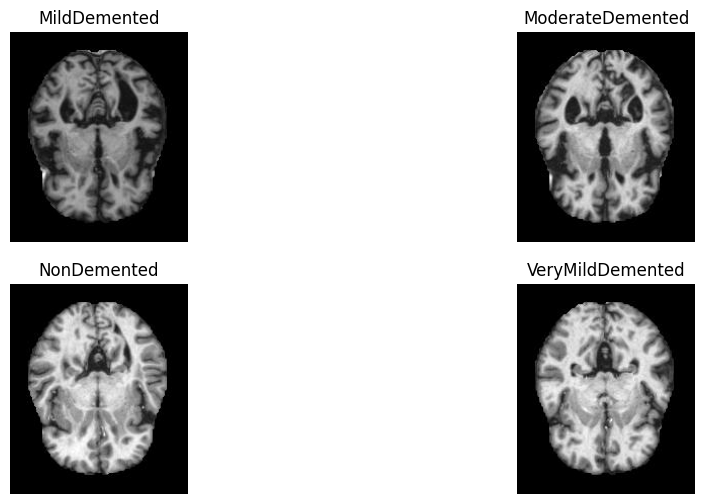

In [9]:
# Dislay the sample images

plt.figure(figsize=(12, 6))
for i, label in enumerate(classes):
    classes_dir = os.path.join(train_directory, label)  
    sample_image = cv2.imread(os.path.join(classes_dir, os.listdir(classes_dir)[0]), cv2.IMREAD_GRAYSCALE)
    plt.subplot(2, 2, i+1)
    plt.imshow(sample_image, cmap='gray')
    plt.title(label)
    plt.axis('off')

plt.show()


# Class Distribution Visualization
- there is some data imbalance in moderatedemented class distribution.

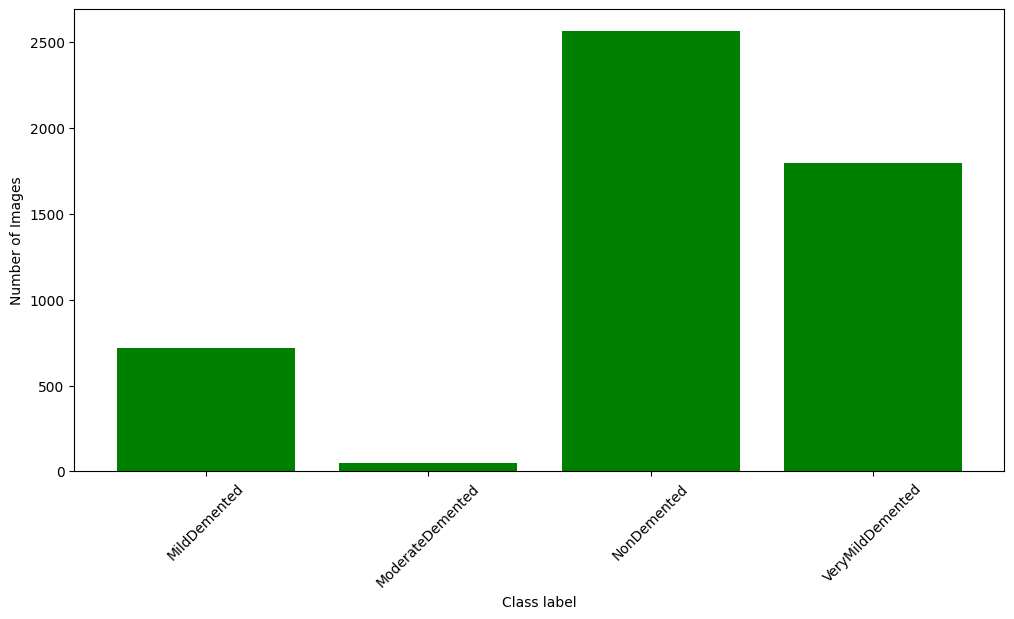

In [10]:
# What does the distribution of class frequencies look like?

# list of all the subdirectories in the main directory
class_counts = [len(os.listdir(os.path.join(train_directory, label ))) for label in classes]
plt.figure(figsize=(12,6))
plt.bar(classes, class_counts, color='green')
plt.xlabel('Class label')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

# Image Statistics

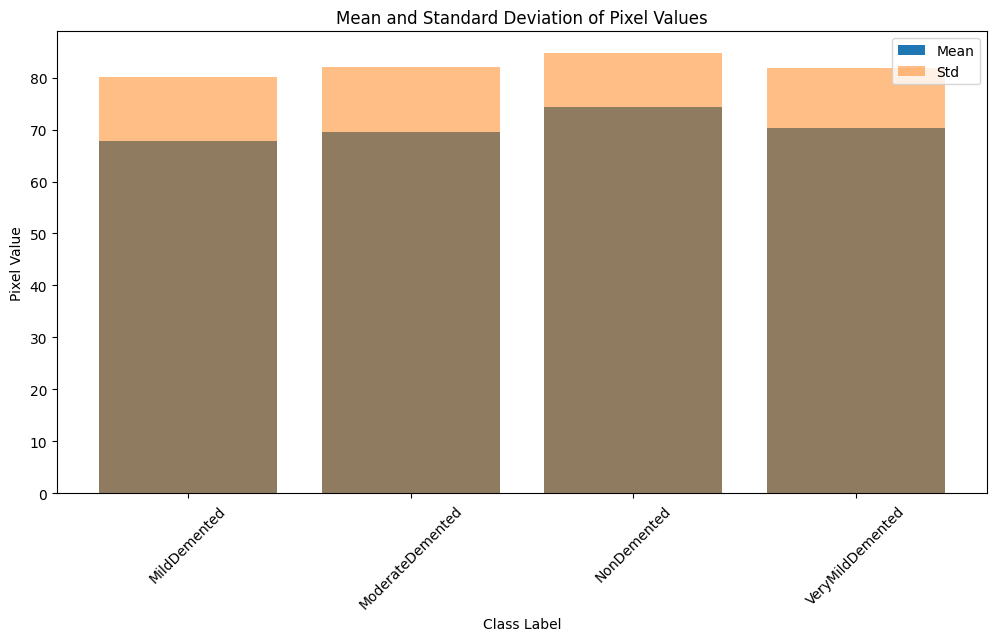

In [11]:


mean_pixel_values = []
std_pixel_values = []

# Calculate mean and std deviation for each class
for label in classes:
    class_dir = os.path.join(train_directory, label)
    class_images = [cv2.imread(os.path.join(class_dir, filename), cv2.IMREAD_GRAYSCALE) 
                    for filename in os.listdir(class_dir) 
                    if os.path.isfile(os.path.join(class_dir, filename))]  # ensure only files are read
    class_images = np.array([img for img in class_images if img is not None])  # filter out any 'None' values from failed reads
    if len(class_images) > 0:  # ensure there are images in the list
        mean_value = np.mean(class_images)
        std_value = np.std(class_images)
        mean_pixel_values.append(mean_value)
        std_pixel_values.append(std_value)

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(classes, mean_pixel_values, label='Mean')
plt.bar(classes, std_pixel_values, label='Std', alpha=0.5)
plt.xlabel('Class Label')
plt.ylabel('Pixel Value')
plt.title('Mean and Standard Deviation of Pixel Values')
plt.legend()
plt.xticks(rotation=45)
plt.show()



# Perform Image Augmentation
- This is process of generating new transformed version of images from the given image dataset to increase it's diversity(')
https://www.picsellia.com/post/image-data-augmentation#:~:text=Image%20data%20augmentation%20is%20the,to%20generate%20new%2C%20augmented%20images.

In [4]:


# Define image size
image_size = 176
dim = (image_size, image_size)

# Define image augmentation parameters as a dictionary
image_augmentation_params = {
    'rescale': 1./255,
    'brightness_range': [0.8, 1.2],
    'zoom_range': [0.99, 1.01],
    'data_format': "channels_last",
    'fill_mode': "constant",
    'horizontal_flip': True
}

# Create an instance of ImageDataGenerator with the specified parameters
image_directory = tf.keras.preprocessing.image.ImageDataGenerator(**image_augmentation_params)

# Create a data generator for your training images using flow_from_directory
train_generator = image_directory.flow_from_directory(
    directory=train_directory,
    target_size=dim,
    batch_size=6400,
    class_mode='categorical'  # Use 'categorical' for multi-class classification
)


Found 5121 images belonging to 4 classes.


In [5]:
# Retrieve the data from the ImageDataGenerator iterator
train_data, train_labels = next(train_generator)

print(train_data.shape, train_labels.shape)

(5121, 176, 176, 3) (5121, 4)


In [6]:


sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, image_size * image_size * 3), train_labels)

train_data = train_data.reshape(-1, image_size, image_size, 3)

print(train_data.shape, train_labels.shape)



(10240, 176, 176, 3) (10240, 4)


In [8]:
# Split the dataset into train, test, and validation sets
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42 )
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [9]:


def conv_block(filters, activation='relu'):
    """Create a convolutional block with batch normalization and max-pooling."""
    
    return Sequential([
        Conv2D(filters, 3, activation=activation, padding='same'),
        Conv2D(filters, 3, activation=activation, padding='same'),
        BatchNormalization(),
        MaxPool2D()
    ])


In [10]:

def dense_block(units, dropout_rate, activation='relu'):
    """Create a dense block with batch normalization and dropout."""
    
    return Sequential([
        Dense(units, activation=activation),
        BatchNormalization(),
        Dropout(dropout_rate)
    ])


In [15]:


def construct_model(act='relu'):
    """Constructing a Sequential CNN architecture for performing the classification task. """
    
    return Sequential([
        Input(shape=(*dim, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')        
    ], name="cnn_model")


In [16]:

# Custom callback to stop training when a certain accuracy threshold is reached

class TerminateOnHighAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.99):
        super(TerminateOnHighAccuracy, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        val_accuracy = logs.get('val_categorical_accuracy')  # Use 'val_accuracy' if it's your validation metric
        if val_accuracy is not None and val_accuracy > self.threshold:
            print(f"\nReached accuracy threshold of {self.threshold}! Terminating training.")
            self.model.stop_training = True
            
terminate_callback = TerminateOnHighAccuracy()

# EarlyStopping callback to ensure the model is always learning
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)


In [17]:

# Create an instance of your Keras model
model = construct_model()

# Define the metrics, callbacks, and compile the model
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='acc'),
    tf.keras.metrics.AUC(name='auc'), 
    tfa.metrics.F1Score(num_classes=4)
]

callbacks = [terminate_callback]

model.compile(
    optimizer='adam',
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=METRICS
)

# Print the model summary
model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 176, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 88, 16)        0         
 D)                                                              
                                                                 
 sequential (Sequential)     (None, 44, 44, 32)        14016     
                                                                 
 sequential_1 (Sequential)   (None, 22, 22, 64)        55680     
                                                                 
 sequential_2 (Sequential)   (None, 11, 11, 128)       221952    
                                                         

In [18]:

# Define the number of epochs for training
epochs = 100

# Train the model
history = model.fit(
    train_data,             # Your training data
    train_labels,           # Your training labels
    validation_data=(val_data, val_labels),  # Your validation data
    callbacks=callbacks,    # List of callbacks
    epochs=epochs           # Number of training epochs
)


Epoch 1/100
132/132 [==============================] - 208s 2s/step - loss: 1.8233 - acc: 0.2695 - auc: 0.5283 - f1_score: 0.2691 - val_loss: 2.0242 - val_acc: 0.2479 - val_auc: 0.4884 - val_f1_score: 0.1027
Epoch 2/100
132/132 [==============================] - 224s 2s/step - loss: 1.5448 - acc: 0.3222 - auc: 0.5845 - f1_score: 0.3205 - val_loss: 2.2895 - val_acc: 0.2459 - val_auc: 0.5014 - val_f1_score: 0.0987
Epoch 3/100
132/132 [==============================] - 228s 2s/step - loss: 1.3175 - acc: 0.4088 - auc: 0.6804 - f1_score: 0.4015 - val_loss: 2.3483 - val_acc: 0.2555 - val_auc: 0.5179 - val_f1_score: 0.1017
Epoch 4/100
132/132 [==============================] - 218s 2s/step - loss: 0.9906 - acc: 0.5566 - auc: 0.8239 - f1_score: 0.5418 - val_loss: 4.0524 - val_acc: 0.2555 - val_auc: 0.5328 - val_f1_score: 0.1017
Epoch 5/100
132/132 [==============================] - 617s 5s/step - loss: 0.8422 - acc: 0.6086 - auc: 0.8684 - f1_score: 0.6005 - val_loss: 0.9016 - val_acc: 0.5472 -

132/132 [==============================] - 222s 2s/step - loss: 0.1203 - acc: 0.9575 - auc: 0.9962 - f1_score: 0.9578 - val_loss: 0.5717 - val_acc: 0.8465 - val_auc: 0.9631 - val_f1_score: 0.8438
Epoch 41/100
132/132 [==============================] - 244s 2s/step - loss: 0.0769 - acc: 0.9733 - auc: 0.9987 - f1_score: 0.9735 - val_loss: 0.3203 - val_acc: 0.9075 - val_auc: 0.9832 - val_f1_score: 0.9056
Epoch 42/100
132/132 [==============================] - 240s 2s/step - loss: 0.0868 - acc: 0.9699 - auc: 0.9979 - f1_score: 0.9701 - val_loss: 0.6879 - val_acc: 0.8074 - val_auc: 0.9486 - val_f1_score: 0.7968
Epoch 43/100
132/132 [==============================] - 249s 2s/step - loss: 0.0926 - acc: 0.9704 - auc: 0.9978 - f1_score: 0.9706 - val_loss: 0.5078 - val_acc: 0.8494 - val_auc: 0.9663 - val_f1_score: 0.8513
Epoch 44/100
132/132 [==============================] - 256s 2s/step - loss: 0.0814 - acc: 0.9745 - auc: 0.9984 - f1_score: 0.9746 - val_loss: 0.6673 - val_acc: 0.7922 - val_auc

132/132 [==============================] - 235s 2s/step - loss: 0.0466 - acc: 0.9862 - auc: 0.9988 - f1_score: 0.9862 - val_loss: 0.5866 - val_acc: 0.8684 - val_auc: 0.9597 - val_f1_score: 0.8654
Epoch 80/100
132/132 [==============================] - 243s 2s/step - loss: 0.0530 - acc: 0.9833 - auc: 0.9988 - f1_score: 0.9834 - val_loss: 0.5188 - val_acc: 0.8818 - val_auc: 0.9609 - val_f1_score: 0.8819
Epoch 81/100
132/132 [==============================] - 287s 2s/step - loss: 0.0358 - acc: 0.9897 - auc: 0.9993 - f1_score: 0.9898 - val_loss: 0.3719 - val_acc: 0.8980 - val_auc: 0.9801 - val_f1_score: 0.8956
Epoch 82/100
132/132 [==============================] - 254s 2s/step - loss: 0.0417 - acc: 0.9878 - auc: 0.9987 - f1_score: 0.9879 - val_loss: 0.4633 - val_acc: 0.8856 - val_auc: 0.9709 - val_f1_score: 0.8860
Epoch 83/100
132/132 [==============================] - 254s 2s/step - loss: 0.0501 - acc: 0.9840 - auc: 0.9990 - f1_score: 0.9841 - val_loss: 0.4602 - val_acc: 0.8837 - val_auc

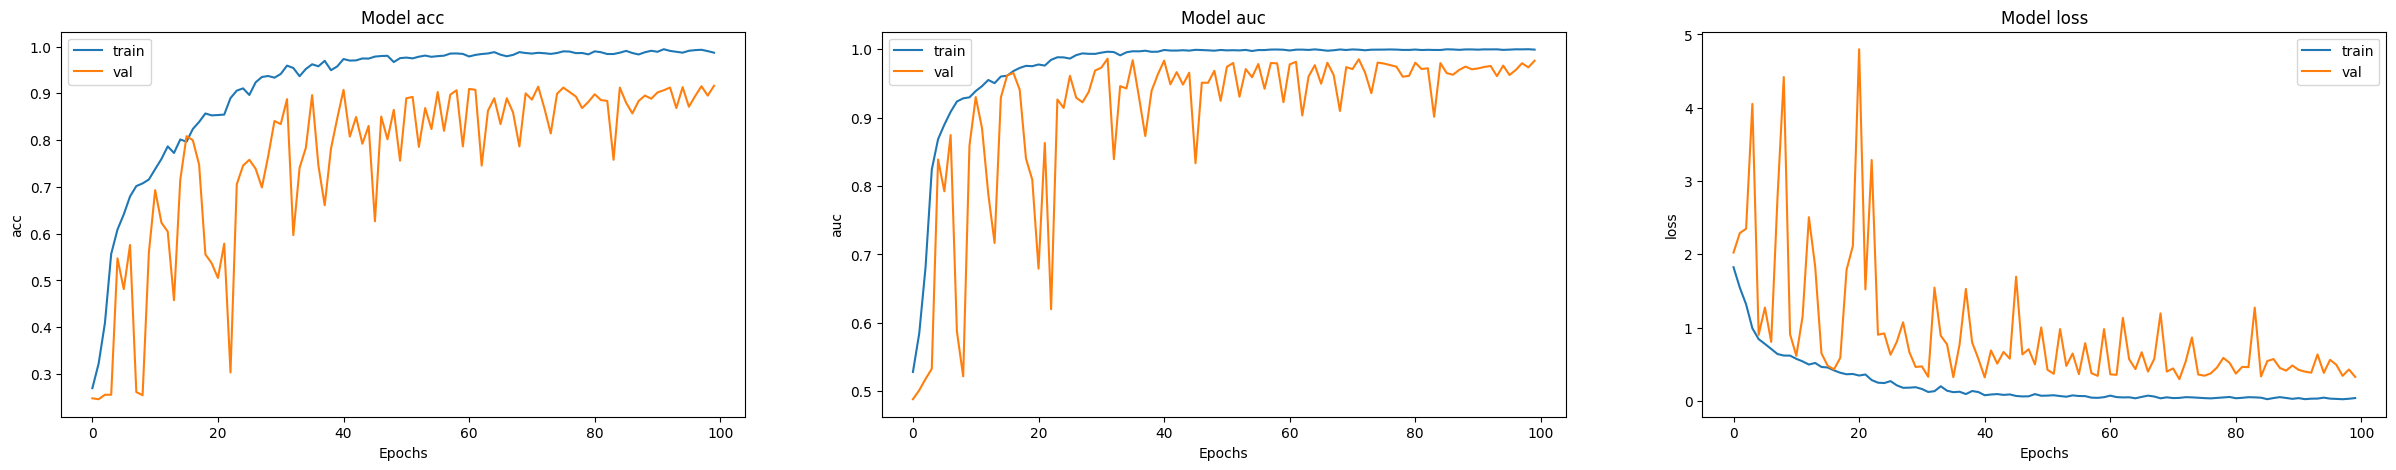

In [23]:
# Plotting the metric during training 

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])




In [26]:
# Evaluate the model on the data

validation_scores =  model.evaluate(train_data, train_labels)
val_scores = model.evaluate(val_data, val_labels)
test_scores = model.evaluate(test_data, test_labels)


print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

41/41 [==============================] - 17s 399ms/step - loss: 0.3688 - acc: 0.9138 - auc: 0.9774 - f1_score: 0.9123
Testing Accuracy: 91.38%


In [29]:
# Print the confusion matrix

pred_labels = model.predict(test_data)
rounded_pred_labels = np.zeros_like(pred_labels)
max_indices = np.argmax(pred_labels, axis=1)

for i, max_index in enumerate(max_indices):
    rounded_pred_labels[i, max_index] = 1

# Now, 'rounded_pred_labels' contains the rounded-off predictions

print(classification_report(test_labels, rounded_pred_labels, target_names=classes))


41/41 [==============================] - 11s 274ms/step
                  precision    recall  f1-score   support

    MildDemented       0.95      0.96      0.95       353
ModerateDemented       1.00      1.00      1.00       321
     NonDemented       0.86      0.87      0.86       321
VeryMildDemented       0.84      0.82      0.83       316

       micro avg       0.91      0.91      0.91      1311
       macro avg       0.91      0.91      0.91      1311
    weighted avg       0.91      0.91      0.91      1311
     samples avg       0.91      0.91      0.91      1311



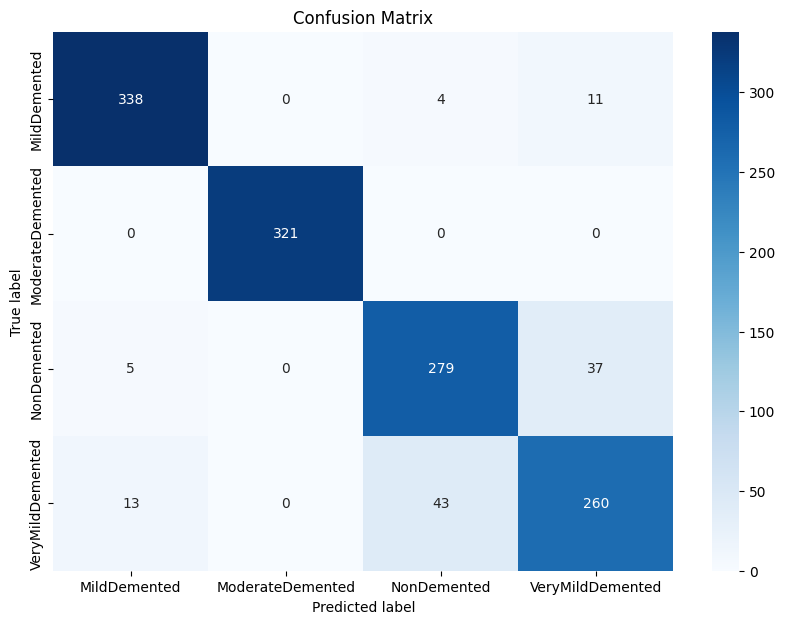

In [35]:


# Calculate confusion matrix
cm = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(rounded_pred_labels, axis=1))

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))

# Using seaborn to create a heatmap of the confusion matrix
# Annot=True to annotate cells with numerical values
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [41]:
model.save('alzheimer_cnn_model.h5')  # saves to an HDF5 file; you can also use '.tf' extension for TensorFlow SavedModel format

C:\Users\chimi\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:

model = load_model('alzheimer_cnn_model.h5')

In [51]:
# Save the architecture
json_string = model.to_json()

with open('model_architecture.json', 'w') as json_file:
    json_file.write(json_string)